# Tutorial: VQE example for the harmonic oscillator

How to use the Variational Quantum Eigensolver (VQE) in `qiskit` to find the ground state of the quantum harmonic oscillator.

## Define the Hamiltonian for the Schroedinger equation

The Hamiltonian is the sum of the kinetic term and the potential term.
Each term is defined using finite differences on a linearly spaced lattice (1D)

Check out [this blog post](https://medium.com/modern-physics/finite-difference-solution-of-the-schrodinger-equation-c49039d161a8).

### The Schroedinger equation

$$-\frac{1}{2} \frac{d^{2} \psi}{d x^{2}}+V(x) \psi(x)=E \psi(x)$$

First we decide how many qubits we want to use and then we select the boundaries for the 1D grid

In [2]:
#@title Choose the number of qubits

# Here's where the number of qubits are set. The Hamiltonian will be have a size of (N-2)x(N-2)
qubits = 6 #@param {type: "slider", min: 1, max: 18}
N = (2**qubits)+2
print(f"The Hamiltonian will be a {N-2}x{N-2} matrix")

The Hamiltonian will be a 64x64 matrix


In [3]:
#@title Enter the lattice (1D) boundaries:

#@markdown lower bound
a =  -6#@param {type: "integer"}
#@markdown upper bound
b =  6#@param {type: "integer"}

### Plot the grid

Discretized grid with 66 sites and step size 0.1846


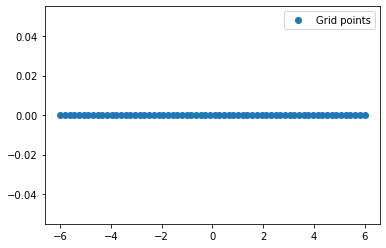

In [4]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Define x grid and step size
x = np.linspace(a,b,N)
h = x[1]-x[0]

print(f"Discretized grid with {N} sites and step size {h:.4f}")
plt.plot(x,np.zeros(x.shape),'o', label="Grid points")
plt.legend(loc='upper right');

In [5]:
print(f"The extremal points will not be considered. That is why we have a {N-2}x{N-2} Hamiltonian but {N} points.")

The extremal points will not be considered. That is why we have a 64x64 Hamiltonian but 66 points.


### Potential term and Kinetic term

We use a quadratic potential (harmonic oscillator):
$$
V(x) = \frac{1}{2} x^2
$$

We use finite differences to compute the kinetic term:
$$
T = \frac{1}{2} \frac{\partial^2 \cdot}{\partial x^2} \rightarrow \frac{1}{2} \Big( \frac{\psi(x+1) - 2\psi(x) + \psi(x-1)}{h^2} \Big)
$$

In [6]:
# Define potential energy function. Change this to change the potential.
def Vpot(x):
    return (1/2)*(x)**2


# Create Kinetic Energy Matrix
T = np.zeros((N-2)**2).reshape(N-2,N-2)
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T[i,j]= -2
        elif np.abs(i-j)==1:
            T[i,j]=1
        else:
            T[i,j]=0

# Create Potential Energy Matrix
V = np.zeros((N-2)**2).reshape(N-2,N-2)
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V[i,j]= Vpot(x[i+1])
        else:
            V[i,j]=0
            
# Create Hamiltonian: a big matrix 😂
H = -T/(2*h**2) + V

#### This is an alternative way without for loops, but using indices only

In [7]:
Tp = np.zeros((N-2,N-2))  # create a kinetic matrix full of zeros 
T_id = np.diag_indices(Tp.shape[0])  # select the indices on the diagonal
T_idp = (T_id[0][:-1],(T_id[1][:-1]+1))  # select the indices above the diagonal y-x=1
T_idm = (T_id[0][:-1]+1,T_id[1][:-1])  # select the indices below the diagonal x-y=1
# fill the 3 "diagonals" with entries for the discretized derivative
Tp[T_id] = -2.0
Tp[T_idp] = Tp[T_idm] = 1.0
# check it is the same as the matrix created with for loops
assert(np.allclose(T,Tp))

In [8]:
Vp = np.zeros((N-2,N-2))
V_id = np.diag_indices(Vp.shape[0])
Vp[V_id] = Vpot(x[1:-1])
assert(np.allclose(V,Vp))

In [9]:
# Create Hamiltonian: a big matrix 😂
Hp = -Tp/(2*h**2) + Vp
assert(np.allclose(H,Hp))

### Plot the Hamiltonian

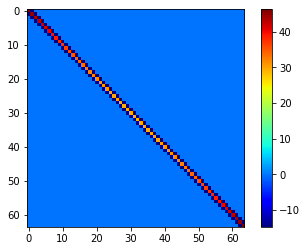

In [10]:
plt.imshow(H, cmap='jet')
plt.colorbar();

## Solve the Schroedinger equation

We solve the Schroedinger equation by finding the eigenvalues and eigenvectors of the Hamiltonian matrix on the 1D grid defined above.

In [11]:
# Find eigenvalues and eigenvectors, then sort them in ascending order
val,vec=np.linalg.eig(H)
z = np.argsort(val)
z = z[0:4]
energies=(val[z])
print("Finite Difference Energies for the first 4 states: ", energies)

Finite Difference Energies for the first 4 states:  [0.49893263 1.49465392 2.48607321 3.47316207]


In [12]:
# Compare finite difference calculation to theoretical calculation
nVec=np.linspace(0,len(energies)-1,len(energies))
En = (nVec + 0.5)
print("Theoretical Energies: ", En)
percentError = ((En-energies)/(energies))*100
print("Percent Error: ", percentError)


Theoretical Energies:  [0.5 1.5 2.5 3.5]
Percent Error:  [0.21393113 0.3576804  0.56019236 0.77272324]


### Plot the wavefunctions

Text(0.5, 1.0, 'normalized wavefunctions for a harmonic oscillator using finite difference method')

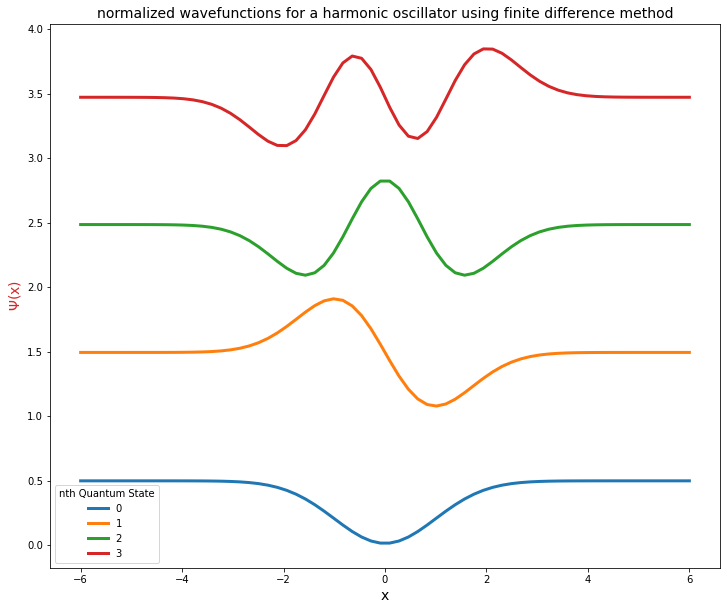

In [13]:
# Plot wavefunctions for first 4 lowest states
plt.figure(figsize=(12,10))
scalingFactor=1.5
for i in range(len(z)):
    y = []
    y = np.append(y,vec[:,z[i]])
    y = np.append(y,0)
    y = np.insert(y,0,0)
    plt.plot(x,scalingFactor*y+energies[i],lw=3, label="{} ".format(i))
plt.xlabel('x', size=14)
plt.ylabel(r'$\Psi$(x)',size=14,color='tab:red')
plt.legend(title="nth Quantum State")
plt.title('normalized wavefunctions for a harmonic oscillator using finite difference method',size=14)


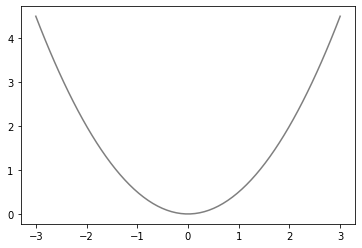

In [14]:

# Create x and potential vectors for plotting

# The next line returns the square root of the last element of the energies array. It will be used when plotting the domain
# of the harmonic potential.
highestEnergy = np.sqrt(2*energies[len(energies)-1]) 
xplot = np.linspace(-np.ceil(highestEnergy),np.ceil(highestEnergy),N)
Vplot = Vpot(xplot)
plt.plot(xplot,Vplot,color='tab:gray')

plt.show()

## Use QISKIT to solve the problem with quantum algorithms

### Convert the Hamiltonian

Now, we take the Hamiltonian matrix and map it onto a qubit operator. There may be better ways to do this now that Qiskit has added new ways to map Hamiltonians to qubit operators.

In [375]:
import warnings
import time

from qiskit.aqua.operators import MatrixOp

start_time = time.time()
warnings.filterwarnings("ignore")

coeff = 1
hamMatrixOp = MatrixOp(primitive=coeff*H)
HamPauliOP = hamMatrixOp.to_pauli_op()
qubitOp = HamPauliOP.to_legacy_op()

print("Size of Hamiltonian:", np.shape(H))
print(qubitOp)
# The next line shows the pauli string. You can comment it so that the output isn't so messy.
#print(qubitOp.print_details())
#print(type(qubitOp))
end_time = time.time()

runtime = end_time-start_time
print('Program runtime: ',runtime)

Size of Hamiltonian: (64, 64)
Representation: paulis, qubits: 6, size: 79
Program runtime:  1.9287173748016357


Next, we create the variational form.

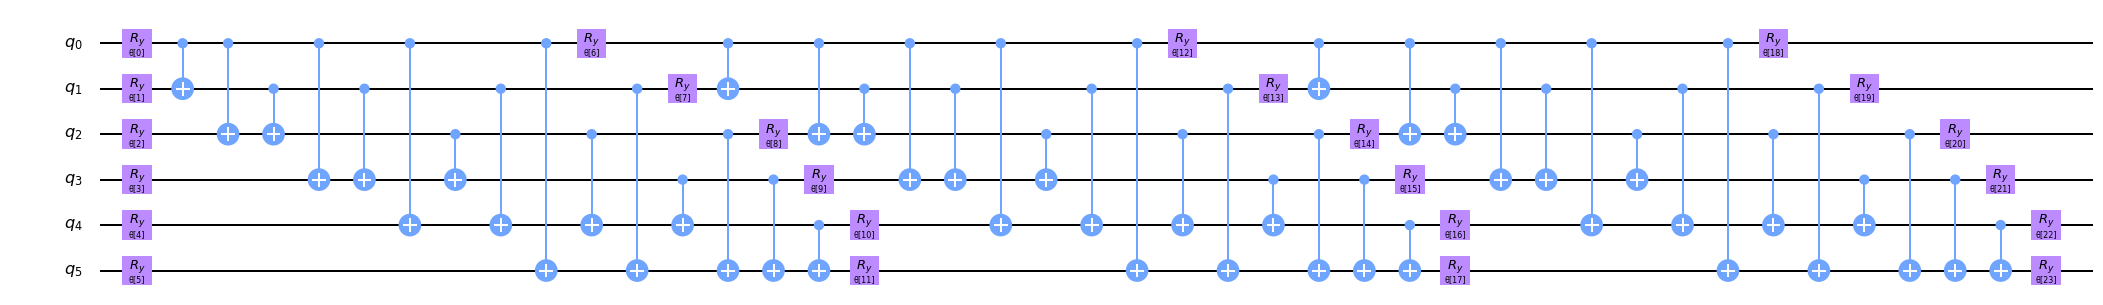

In [376]:
from qiskit.circuit.library import EfficientSU2

var_form = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry'], entanglement="full", reps=3)
display(var_form.draw(output='mpl',fold=100))

In the next cell, we check the exact minimum eigenvalue of the qubit operator to make sure that our Hamiltonian mapped correctly.

In [377]:
from qiskit.aqua.algorithms import NumPyEigensolver

exact_solution = NumPyEigensolver(qubitOp).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

Exact Result: [0.49893263]


### Run the VQE algorithm

Now, we can run the VQE algorithm.

We can use multiple simulators from the QISKIT ecosystem:

- [A statevector simulator](https://qiskit.org/documentation/stubs/qiskit.providers.aer.StatevectorSimulator.htm)
- [A Qasm simulator](https://qiskit.org/documentation/stubs/qiskit.providers.aer.QasmSimulator.html)

In [378]:
from qiskit import Aer  # change this to Aer for C++ compiled code and the option to run on the GPU
from qiskit.aqua.algorithms import VQE

#### Statevector simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html)

In [379]:
# This is a callback function that will allow us to store information about the optimizer while the VQE is running.
# This is called when instantiating an object of the VQE class.

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [380]:
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, L_BFGS_B, NELDER_MEAD

start_time = time.time()
warnings.filterwarnings("ignore")
backend = Aer.get_backend("statevector_simulator")

countArr = []
valArr = []
vqe_result = []
optimizerList = [SLSQP(maxiter=50000), COBYLA(maxiter=20000), L_BFGS_B(maxfun=20000, maxiter=30000)]

for optimizer in optimizerList:

    counts = []
    values = []
        
    countArr.append(counts)
    valArr.append(values)
        
    vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
    ret = vqe.run(backend)
    vqe_result.append(np.real(ret['eigenvalue']))

print("VQE Result:", np.array(vqe_result)/coeff)

end_time = time.time()
runtime = end_time-start_time
print('Program runtime:',runtime, "s")

VQE Result: [0.66488468 0.86746133 1.30456735]
Program runtime: 158.04247570037842 s


Finally, we plot a convergence plot of the VQE results.

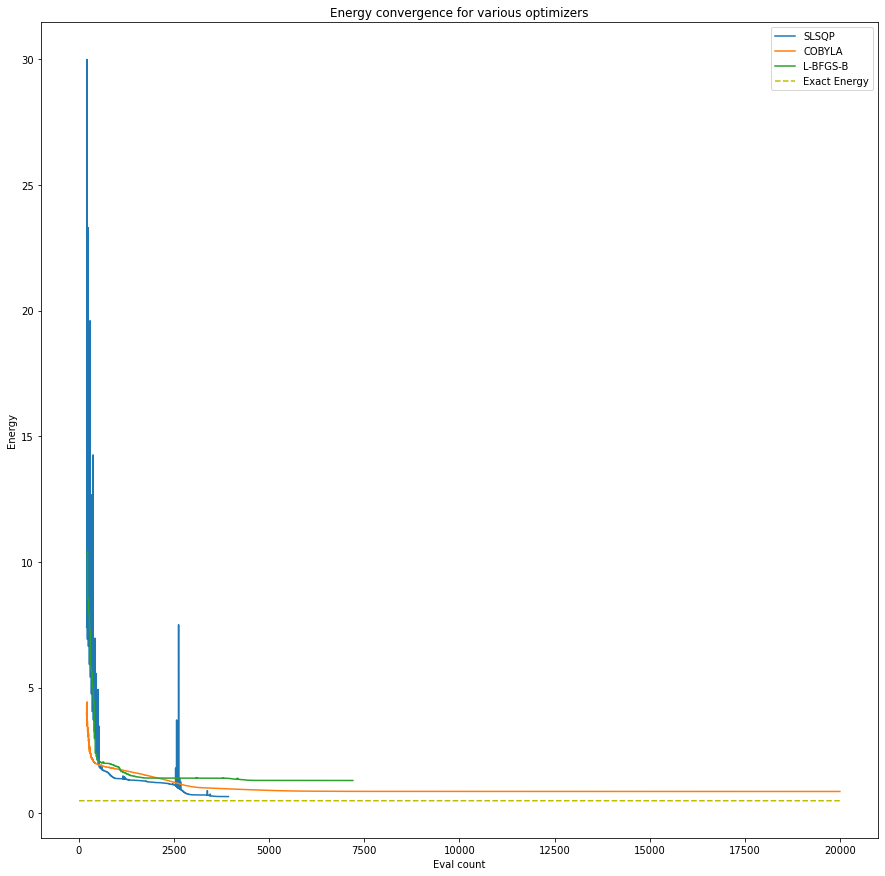

In [381]:
# Plot all of the optimizers in a single convergence plot. If you see that the optimizer isn't converging,
# increase the maximum iterations or maximum function evaluations in the optimizer list above.

labelList = ["SLSQP", "COBYLA", "L-BFGS-B"]

plt.figure(figsize=(15,15))

for i in range(0,len(optimizerList)):
    # Limit the range of the plot in order to make the convergence of each optimizer more visible.
    plt.plot(countArr[i][200:len(countArr[i])-1], valArr[i][200:len(valArr[i])-1], label=labelList[i])

plt.plot(countArr[1],[np.real(energies[0])]*len(countArr[1]), 'y--',label="Exact Energy")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence for various optimizers')
plt.legend(loc='upper right')

#### QASM simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/03_vqe_simulation_with_noise.html#Performance-without-noise)

In [ ]:
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import QuantumInstance


start_time = time.time()
warnings.filterwarnings("ignore")

backendQasm = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backendQasm, shots=100)
optimizer = SPSA(max_trials=600)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# Run the VQE
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
ret = vqe.run(quantum_instance)
vqe_result = np.real(ret['eigenvalue'])
print("VQE Result:", vqe_result)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime:',runtime, "s")

In [ ]:
# Plot convergence plot
plt.figure(figsize=(12,10))
plt.plot(counts, values, label="SPSA")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence for various optimizers')
plt.legend(loc='upper right')

In [ ]:
import qiskit
qiskit.__qiskit_version__